from: https://medium.com/analytics-vidhya/lenet-with-tensorflow-a35da0d503df

In [ ]:
!pip install extra-keras-datasets

In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, losses, callbacks
from extra_keras_datasets import emnist
import time
import string
import math

# Utils

In [ ]:
# CONST
TRAIN_PERCENTAGE = .6
LENET_INPUT = (32, 32, 1) # as defined in the paper
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
class Data:
  def __init__(self, x, y):
    assert x.shape[0] == y.shape[0], 'Must have same number of inputs and labels'
    self.x = x
    self.y = y

  def preprocess(self):
    """Apply padding to convert 28x28 to 32x32 and add a dim (because of grayscale only 1channel)"""
    self.x = tf.pad(self.x, [[0, 0], [2, 2], [2, 2]]) / 255
    self.x = tf.expand_dims(self.x, axis=3)


class TrainData(Data):
  def __init__(self, x, y):
    super().__init__(x, y)
    self.x_train, self.y_train, self.x_val, self.y_val = [], [], [], []


  def split_train_val(self, train_percentage):
    n_train = int(self.x.shape[0] * train_percentage)
    self.x_train = self.x[:n_train]
    self.y_train = self.y[:n_train]
    self.x_val = self.x[n_train:]
    self.y_val = self.y[n_train:]

    assert self.x.shape[0] == self.x_train.shape[0] + self.x_val.shape[0], 'Data missing'

  
  def get_val_data(self):
    return self.x_val, self.y_val

In [ ]:
def min_occuring_label(data):
  u, counts = np.unique(data, return_counts=True)
  stats = dict(zip(u, counts))
  return min(stats.items(), key=lambda x: x[1]) 


def keep_smallest(data):
  x, y = data
  x_kept, y_kept = [], []

  kept_occurences = {k: 0 for k in np.unique(y)}
  index, min_occ = min_occuring_label(y)

  for idx, label in enumerate(y):
    if kept_occurences[label] > min_occ:
      continue
    
    x_kept.append(x[idx])
    y_kept.append(y[idx])
    kept_occurences[label] += 1

  return np.array(x_kept), np.array(y_kept)


def load_dataset(name, limit_to_min_occurence=False):
  assert name in ['mnist', 'letters', 'balanced', 'byclass']

  train, test = emnist.load_data(type=name)

  if limit_to_min_occurence:
    train = keep_smallest(train)
    test = keep_smallest(test)
  
  train = TrainData(train[0], train[1])
  test = Data(test[0], test[1])
  train.preprocess()
  test.preprocess()
  train.split_train_val(TRAIN_PERCENTAGE)

  return train, test

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def plot_conf_matrix(model, test, labels):
  from sklearn.metrics import confusion_matrix
  import seaborn as sn
  pred = np.argmax(model.predict(test.x),axis=1)
  print(pred)
  mat = confusion_matrix(test.y, pred, labels=labels)
  #sn.set(font_scale=1.4) # for label size
  sn.heatmap(mat, annot=True)#, annot_kws={"size": 16}) # font size

  plt.show()

# Networks

In [ ]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = callbacks.LearningRateScheduler(lr_decay, verbose=True)

## BNCNN

In [ ]:
class BNCNN:
  def __init__(self, input_shape, number_of_classes) -> None:
    self.model = models.Sequential()
    strides = 2
    #self.model.add(tf.keras.layers.Reshape(input_shape=(32,32,1), target_shape=(28, 28, 1)))
    #channels = [32, 48, 64, 80, 96, 112, 128, 144, 160, 176]
    channels = [6, 16, 32, 120]
    self.model = self._add_conv_block(self.model, channels[0], 3, input_shape=input_shape, strides=strides)
    for c in channels[1:]:
      self.model = self._add_conv_block(self.model, c, 3, strides=strides)
    #self.model = self._add_conv_block(self.model, 32, 6, strides=1)
    #self.model.add(layers.Flatten())
    #self.model.add(layers.Dense(200, use_bias=False))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(84, use_bias=False))
    self.model.add(layers.BatchNormalization(center=True, scale=False))
    self.model.add(layers.Activation('relu'))
    self.model.add(layers.Dropout(0.3))
    self.model.add(layers.Dense(number_of_classes, activation='softmax'))
    self.model.summary()


  def _add_conv_block(self, model, filters, ksize, strides=1, input_shape = None):
    if input_shape:
      self.model.add(layers.Conv2D(filters, ksize, activation='relu', strides=strides, input_shape=input_shape, use_bias=False))
    else:
      self.model.add(layers.Conv2D(filters, ksize, activation='relu', strides=strides, use_bias=False))
    self.model.add(layers.BatchNormalization(center=True, scale=False))
    self.model.add(layers.Activation('relu'))
    return self.model

  def train(self, train_data:TrainData, batch_size:int, epochs:int):
    self.model.compile(optimizer = 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
    return self.model.fit(
        train_data.x_train, train_data.y_train,
        batch_size = batch_size, epochs = epochs,
        validation_data = train_data.get_val_data(),
        callbacks = [lr_decay_callback]
    )

## LENET

In [ ]:
class LeNet:
  def __init__(self, input_shape, number_of_classes, model=None):
    self.model = models.Sequential()
    self.model.add(layers.Conv2D(6, 5, activation='relu', input_shape=input_shape))
    self.model.add(layers.AveragePooling2D(2))
    self.model.add(layers.Activation('relu'))
    self.model.add(layers.Conv2D(16, 5, activation='relu'))
    self.model.add(layers.AveragePooling2D(2))
    self.model.add(layers.Activation('relu'))
    self.model.add(layers.Conv2D(120, 5, activation='relu'))
    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(84, activation='relu'))
    self.model.add(layers.Dense(number_of_classes, activation='softmax'))
    self.model.summary()
    

  def train(self, train_data:TrainData, batch_size:int, epochs:int):
    self.model.compile(optimizer = 'adam', loss = losses.sparse_categorical_crossentropy, metrics = ['accuracy'])
    return self.model.fit(
        train_data.x_train, train_data.y_train,
        batch_size = batch_size, epochs = epochs,
        validation_data = train_data.get_val_data(),
        callbacks = [
                     callbacks.ReduceLROnPlateau(monitor='val_loss')
        ]
    )

In [ ]:
def trainer(name, n_classes, limit=False, model='lenet'):
  train, test = load_dataset(name, limit)
  if model == 'lenet':
    net = LeNet(LENET_INPUT, n_classes)
  elif model == 'bncnn':
    net = BNCNN(LENET_INPUT, n_classes)

  t = time.time()
  print(train.x[0].shape)
  history = net.train(train, batch_size = BATCH_SIZE, epochs = EPOCHS)

  print(f'Training time {time.time() - t}s')

  plot_history(history)

  loss, test_acc = net.model.evaluate(test.x, test.y)
  test_acc = f'{test_acc:.4f}'
  print(f'Test accuracy {test_acc}')
  test_acc = test_acc.replace('.','')
  net.model.save(f'./{model}_{name}_{test_acc}.h5')
  return net, history

# Train

## MNIST LENET

INFO:root:Loading dataset = emnist


743915520/743900280 [==============================] - 11s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 5, 5, 16)          0

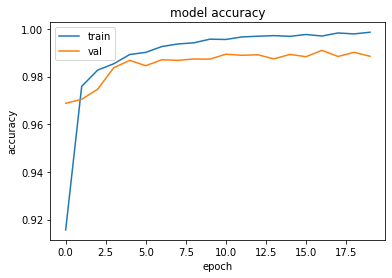

313/313 [==============================] - 2s 4ms/step - loss: 0.0539 - accuracy: 0.9893
Test accuracy 0.9893


In [ ]:
net, history = trainer('mnist', 10, True)

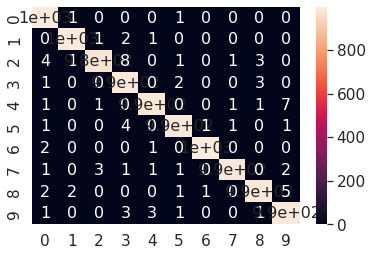

In [ ]:
model = tf.keras.models.load_model('lenet_mnist_09919.h5')
plot_conf_matrix(model, test)

## EMNIST LENET

INFO:root:Loading dataset = emnist


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 activation_2 (Activation)   (None, 14, 14, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_3 (Activation)   (None, 5, 5, 16)         

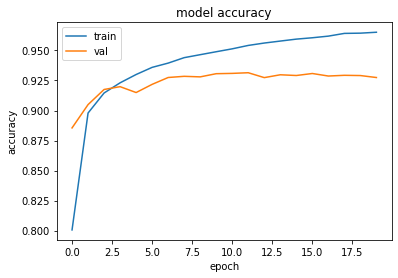

650/650 [==============================] - 2s 3ms/step - loss: 0.2925 - accuracy: 0.9248
Test accuracy 0.9248


In [ ]:
net, history = trainer('letters', 27)

## EMNIST (CHIFFRES + LETTRES)

INFO:root:Loading dataset = emnist


Epoch 1/40
2206/2206 [==============================] - 17s 7ms/step - loss: 1.1463 - accuracy: 0.6514 - val_loss: 1.3363 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 2/40
2206/2206 [==============================] - 16s 7ms/step - loss: 0.7048 - accuracy: 0.7552 - val_loss: 1.2596 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 3/40
2206/2206 [==============================] - 17s 8ms/step - loss: 0.6236 - accuracy: 0.7751 - val_loss: 1.1292 - val_accuracy: 0.5228 - lr: 0.0010
Epoch 4/40
2206/2206 [==============================] - 16s 7ms/step - loss: 0.5762 - accuracy: 0.7891 - val_loss: 1.1852 - val_accuracy: 0.5354 - lr: 0.0010
Epoch 5/40
2206/2206 [==============================] - 17s 8ms/step - loss: 0.5444 - accuracy: 0.7971 - val_loss: 1.0556 - val_accuracy: 0.5538 - lr: 0.0010
Epoch 6/40
2206/2206 [==============================] - 16s 7ms/step - loss: 0.5177 - accuracy: 0.8062 - val_loss: 1.1047 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 7/40
2206/2206 [==============================

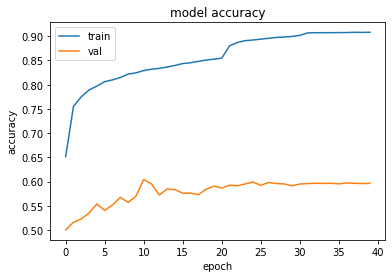

617/617 [==============================] - 2s 4ms/step - loss: 1.0947 - accuracy: 0.7135
Test accuracy 0.7135


In [ ]:
net, history = trainer('byclass', 62, limit=True)

## BNCNN

INFO:root:Loading dataset = emnist


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 30, 30, 6)         54        
                                                                 
 batch_normalization_38 (Bat  (None, 30, 30, 6)        18        
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 30, 30, 6)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 16)        864       
                                                                 
 batch_normalization_39 (Bat  (None, 14, 14, 16)       48        
 chNormalization)                                                
                                                                 
 activation_41 (Activation)  (None, 14, 14, 16)      

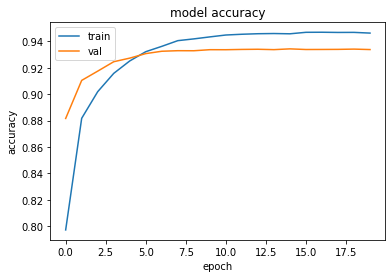

650/650 [==============================] - 2s 3ms/step - loss: 0.2163 - accuracy: 0.9327
Test accuracy 0.9327


In [ ]:
net, history = trainer('letters', 27, model='bncnn')

INFO:root:Loading dataset = emnist


(32, 32, 1)

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
13087/13087 [==============================] - 79s 6ms/step - loss: 0.6081 - accuracy: 0.8006 - val_loss: 0.4575 - val_accuracy: 0.8390 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.00666.
Epoch 2/20
13087/13087 [==============================] - 76s 6ms/step - loss: 0.4801 - accuracy: 0.8352 - val_loss: 0.4121 - val_accuracy: 0.8549 - lr: 0.0067

Epoch 3: LearningRateScheduler setting learning rate to 0.004435560000000001.
Epoch 3/20
13087/13087 [==============================] - 74s 6ms/step - loss: 0.4386 - accuracy: 0.8468 - val_loss: 0.3909 - val_accuracy: 0.8598 - lr: 0.0044

Epoch 4: LearningRateScheduler setting learning rate to 0.0029540829600000007.
Epoch 4/20
13087/13087 [==============================] - 73s 6ms/step - loss: 0.4126 - accuracy: 0.8544 - val_loss: 0.3851 - val_accuracy: 0.8643 - lr: 0.0030

Epoch 5: LearningRateScheduler setting learning rate to 0.0

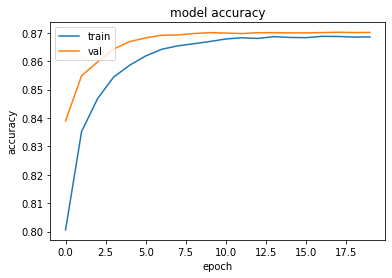

3636/3636 [==============================] - 10s 3ms/step - loss: 0.3653 - accuracy: 0.8711
Test accuracy 0.8711


In [ ]:
net, history = trainer('byclass', 62, model='bncnn')

In [ ]:
net, history = trainer('mnist', 10, model='bncnn')

INFO:root:Loading dataset = emnist


ValueError: ignored

# Split Données

In [ ]:
train, test = load_dataset('byclass', True)

INFO:root:Loading dataset = emnist


In [ ]:
labels = list(range(10)) + list (string.ascii_letters)

upper = list(string.ascii_uppercase)
lower = list(string.ascii_lowercase)

pred = [labels[i] for i in train.y]
merged = []

for y in pred:
  if y in range(10) or y in upper:
    merged.append(y)
  else:
    merged.append(upper[lower.index(y)])

print(np.unique(merged))


numbers = [p for p in merged if p in range(10)]
letters = [p for p in merged if p in list(string.ascii_uppercase)]

assert len(numbers) + len(letters) == len(pred)
print(len(numbers))
print(len(letters))

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
18970
98643


In [ ]:
def plot_subhistogram(data, bins):
  data.sort()
  bins = np.arange(bins + 1) - 0.5
  n, bins, patches = plt.hist(x=data, bins=bins, color='#0504aa', alpha=0.7, rwidth=0.5)
  #plt.bar(data)

In [ ]:
u, counts = np.unique(merged, return_counts=True)
stats = dict(zip(u, counts))
min(stats, key=stats.get)

'0'

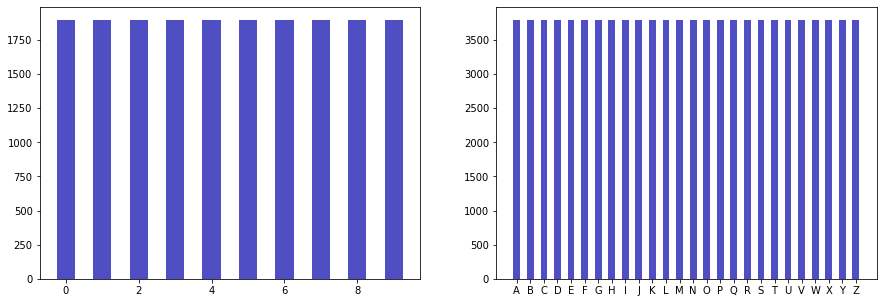

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plot_subhistogram(numbers, 10)

plt.subplot(1,2,2)
plot_subhistogram(letters, 26)
plt.show()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
#plt.xticks(test.y, labels)

In [ ]:
train, test = emnist.load_data(type='byclass')
train_x, train_y = train
test_x, test_y = test

INFO:root:Loading dataset = emnist


In [ ]:
min_occuring_label(merged)

('K', 848)

In [ ]:
x_kept, y_kept = keep_smallest(train_x, train_y)

u, counts = np.unique(y_kept, return_counts=True)
dict(zip(u, counts))

{0: 1897,
 1: 1897,
 2: 1897,
 3: 1897,
 4: 1897,
 5: 1897,
 6: 1897,
 7: 1897,
 8: 1897,
 9: 1897,
 10: 1897,
 11: 1897,
 12: 1897,
 13: 1897,
 14: 1897,
 15: 1897,
 16: 1897,
 17: 1897,
 18: 1897,
 19: 1897,
 20: 1897,
 21: 1897,
 22: 1897,
 23: 1897,
 24: 1897,
 25: 1897,
 26: 1897,
 27: 1897,
 28: 1897,
 29: 1897,
 30: 1897,
 31: 1897,
 32: 1897,
 33: 1897,
 34: 1897,
 35: 1897,
 36: 1897,
 37: 1897,
 38: 1897,
 39: 1897,
 40: 1897,
 41: 1897,
 42: 1897,
 43: 1897,
 44: 1897,
 45: 1896,
 46: 1897,
 47: 1897,
 48: 1897,
 49: 1897,
 50: 1897,
 51: 1897,
 52: 1897,
 53: 1897,
 54: 1897,
 55: 1897,
 56: 1897,
 57: 1897,
 58: 1897,
 59: 1897,
 60: 1897,
 61: 1897}

# Tests random

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

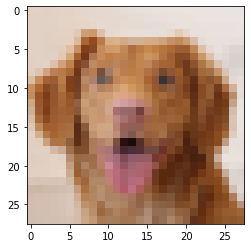

In [ ]:
img = Image.open('./test.jpg') # image extension *.png,*.jpg
new_width  = 28
new_height = 28
img = img.resize((new_width, new_height))
plt.imshow(img)

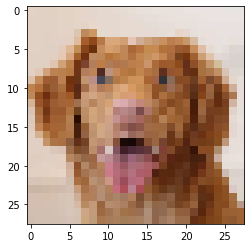

In [ ]:
img = cv2.imread('./test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_width  = 28
new_height = 28
img = cv2.resize(img, (new_width, new_height))
plt.imshow(img)

In [ ]:
img = np.zeros((28,28))
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=-1)
img.shape

(1, 28, 28, 1)

In [ ]:
import string

In [ ]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
labels = list(range(10)) + list (string.ascii_letters)

In [ ]:
labels.index('A')

36

In [ ]:
labels[15]

'f'

In [ ]:
train, test = load_dataset('mnist')

INFO:root:Loading dataset = emnist


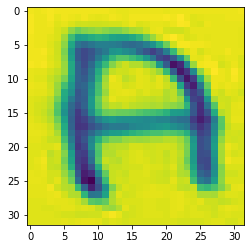

In [ ]:
img = cv2.imread('./A.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32, 32))

plt.imshow(img)

In [ ]:
img = (img - np.min(img)) / (np.max(img) - np.min(img))
np.max(img)

1.0

In [ ]:
np.min(img)

0.0

In [ ]:
a = [1,2,3]
a[1:]

[2, 3]